### Evaluation des 10 meilleurs modèles issus de l'optimisation des hyperparamètres

#### Importation des modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr,loguniform
import qsar_utils as qu
import pickle
import ast

#### Chargement des données

In [2]:
df_norm = pd.read_csv("data/qsar_fish_toxicity_norm.csv")
LC50 = df_norm["LC50"]
data = df_norm.drop(columns=["LC50"])
best_models = pd.read_csv("nestedCV_MLP/best_models.csv")
best_models = best_models[["nb_neurones","alpha","activation","hidden_layer_sizes","learning_rate_init"]]
# conversion de la colonne avec les couches en tuple
best_models["hidden_layer_sizes"] = best_models["hidden_layer_sizes"].apply(lambda x: ast.literal_eval(x))

#### Entrainement des 10 meilleurs modèles 5 fois en cross validation
**/!\\ Ceci est très long (environ une nuit sur le serveur)**

In [ ]:
df_final = pd.DataFrame(columns=["nb_neurones","alpha","activation","hidden_layer_sizes","learning_rate_init","no_AD","strict","soft"])
n_model_tot = len(best_models)
cpt =  0
for model in best_models.iterrows():
    cpt += 1
    param = model[1].to_dict()
    scores = {"no_AD": [], "strict": [], "soft": []}
    mean_score = {"no_AD": 0, "strict": 0, "soft": 0}
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=42+i)
        for train_index, test_index in kf.split(data):
            knn = NearestNeighbors(n_neighbors=6, metric='euclidean')
            model = MLPRegressor(
                activation=param["activation"],
                alpha=param["alpha"],
                hidden_layer_sizes=param["hidden_layer_sizes"],
                learning_rate_init=param["learning_rate_init"],
                random_state=42,
                max_iter = 100000
            )
            X_train, X_test = data.iloc[train_index], data.iloc[test_index]
            y_train, y_test = LC50.iloc[train_index], LC50.iloc[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score_noAD,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=None)
            score_strict,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=0.13)
            score_soft,_,_ = qu.apply_AD_and_score(X_train, X_test, y_test, y_pred, knn, threshold=0.2)
            scores["no_AD"].append(score_noAD)
            scores["strict"].append(score_strict)
            scores["soft"].append(score_soft)

    row_final = pd.DataFrame({
        "nb_neurones": [param["nb_neurones"]],
        "alpha": [param["alpha"]],
        "activation": [param["activation"]],
        "hidden_layer_sizes": [param["hidden_layer_sizes"]],
        "learning_rate_init": [param["learning_rate_init"]],
        "no_AD": [np.mean(scores["no_AD"])],
        "strict": [np.mean(scores["strict"])],
        "soft": [np.mean(scores["soft"])]
    })
    df_final = pd.concat([df_final, row_final])
    df_final.to_csv("nestedCV_MLP/Evalution_finale_temp.csv", index=False)
    print(f"{cpt}/{n_model_tot}", end = "\r")
print(f'{cpt}/{n_model_tot}')

df_final.to_csv("nestedCV_MLP/Evalution_finale.csv", index=False)

/tmp/ipykernel_415792/2282275485.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_final = pd.concat([df_final, row_final])


/home/be203133/.conda/envs/projet_ia/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [9]:
df_final = pd.read_csv("nestedCV_MLP/Evalution_finale.csv")
df_final["num_model"] = df_final.index

#### Visualisation des résultats

In [10]:
df_final.sort_values(by="no_AD", ascending=False, inplace=True)
df_final

,nb_neurones,alpha,activation,hidden_layer_sizes,learning_rate_init,no_AD,strict,soft,num_model
8,500,0.005044,relu,"(56, 56, 56, 56, 56, 55, 55, 55, 55)",0.000028,0.620829,0.721395,0.661284,8
10,50,0.000381,tanh,"(13, 13, 12, 12)",0.002464,0.613333,0.714485,0.648555,10
3,1000,0.000542,relu,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.000021,0.613199,0.728026,0.662758,3
24,50,0.000016,tanh,"(13, 13, 12, 12)",0.000442,0.609865,0.709538,0.647783,24
4,50,0.000076,relu,"(5, 5, 5, 5, 5, 5, 5, 5, 5, 5)",0.001118,0.609857,0.704322,0.647117,4
23,1000,0.000993,relu,"(250, 250, 250, 250)",0.000013,0.609521,0.720112,0.659311,23
6,10,0.001876,tanh,"(4, 3, 3)",0.003510,0.609005,0.705813,0.648180,6
0,100,0.000100,relu,"(17, 17, 17, 17, 16, 16)",0.007217,0.608237,0.713407,0.653629,0
9,1000,0.002793,relu,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.000010,0.605410,0.704285,0.647785,9
21,200,0.006139,tanh,"(34, 34, 33, 33, 33, 33)",0.000274,0.604700,0.699988,0.641397,21


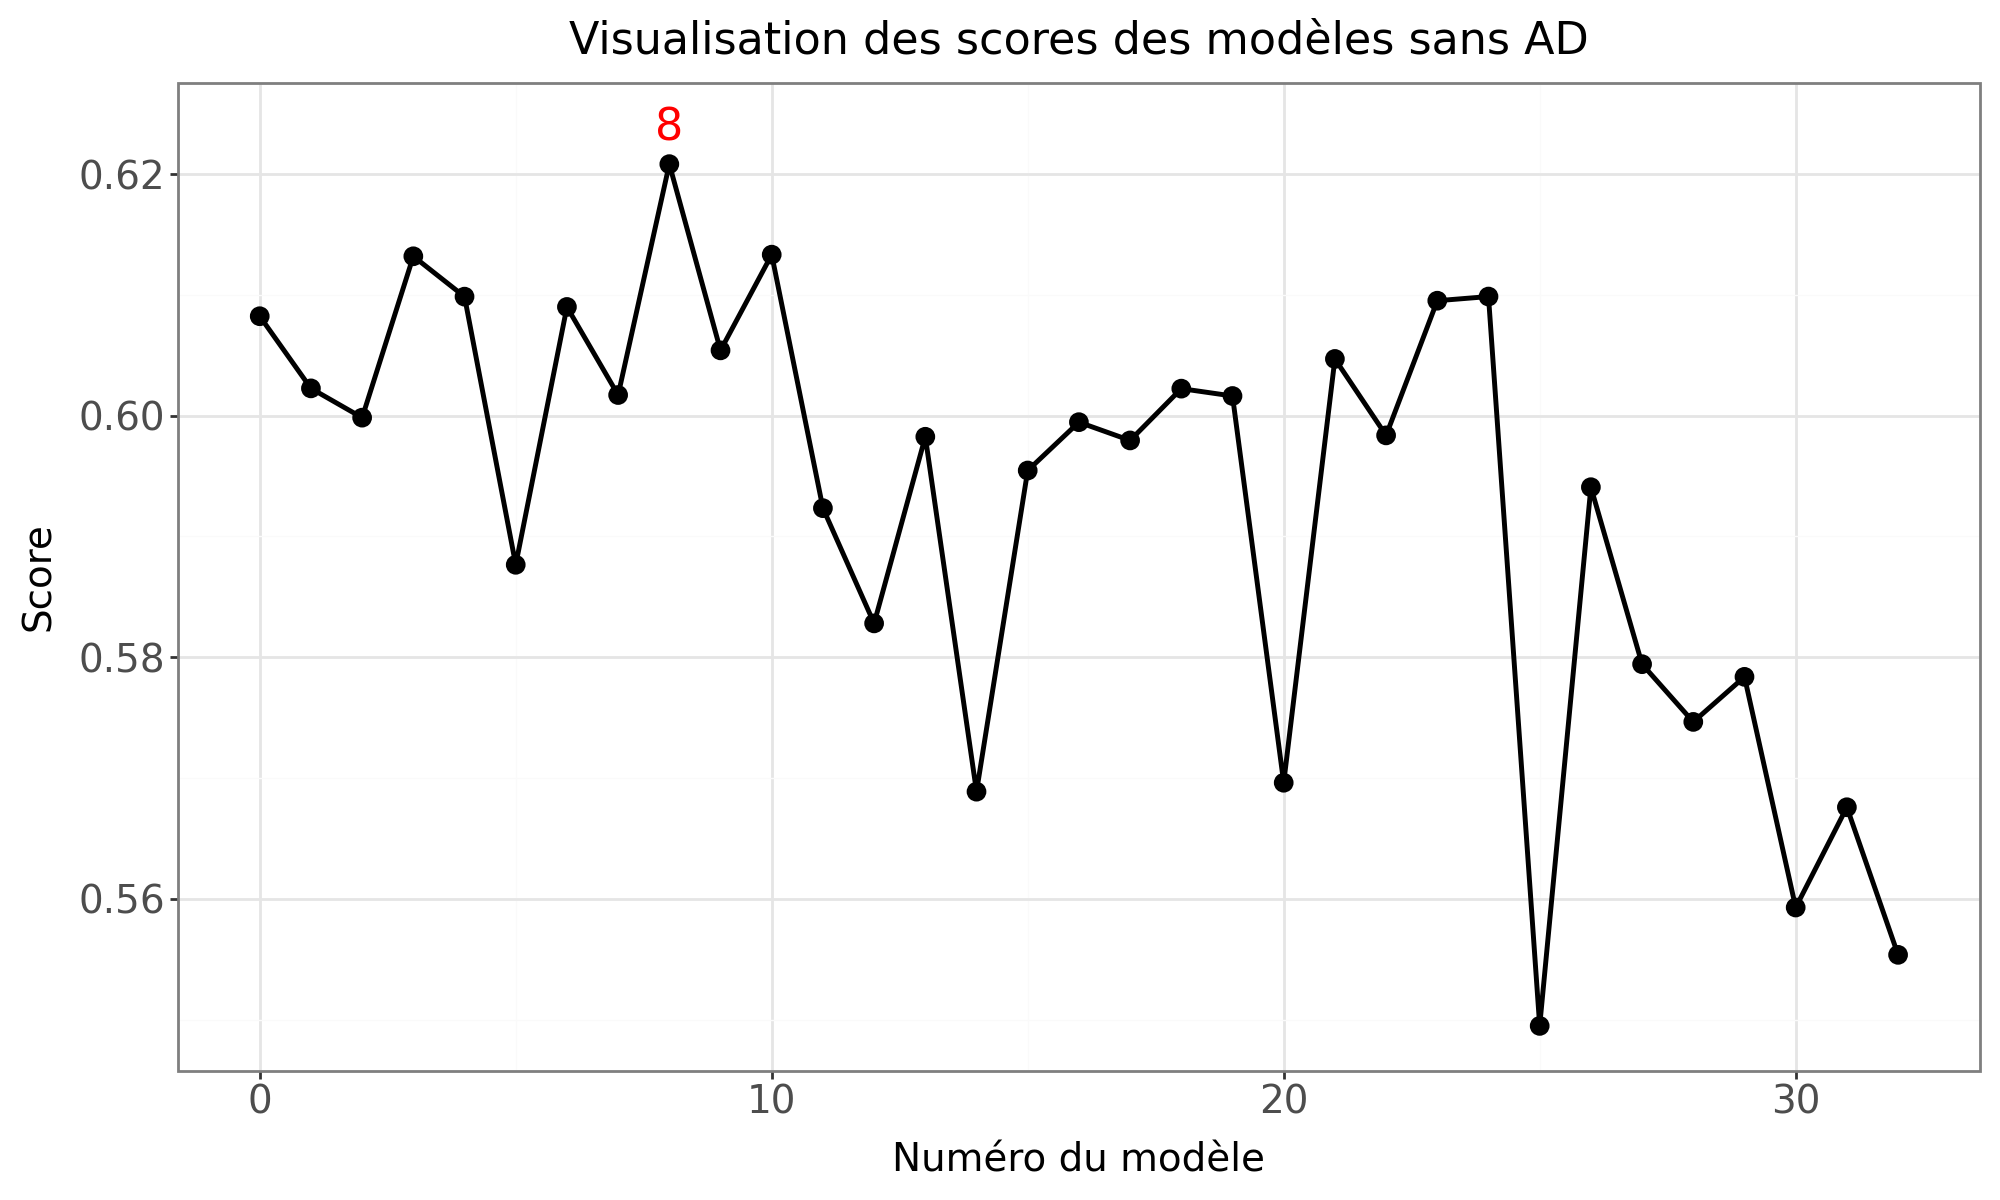

In [75]:
from plotnine import *


def gglineplot(df, x, y, df_best , title, xlabel, ylabel):

    plot = (
        ggplot(data = df, mapping = aes(x = x, y = y)) 
        + geom_point(size = 3) 
        + geom_line(size = 1) 
        + geom_text(aes(label = "num_model"), data = df_best, nudge_y = 0.003, color = "red", size = 16)
        + theme_bw()
        + xlab(xlabel)
        + ylab(ylabel)
        + ggtitle(title)
        + theme(axis_text = element_text(size = 14), 
                axis_title = element_text(size = 14),
                plot_title = element_text(size = 16),
                figure_size=(10,6))
    )
    return plot

# Extraction du meilleur modèle
idx_max = df_final["no_AD"].idxmax()
df_best = df_final.loc[[idx_max]].copy()
p = gglineplot(df_final, "num_model", "no_AD", df_best, 
               "Visualisation des scores des modèles sans AD", "Numéro du modèle", "Score")
p
